In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
%matplotlib inline

In [2]:

def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   

## 다운로드한 데이터 형태

```
    chapter3/
        dogsandcats/
            train/
                dog.183.jpg
                cat.2.jpg
                cat.17.jpg
                dog.186.jpg
                cat.27.jpg
                dog.193.jpg
  

```

```
    chapter3/
        dogsandcats/
            train/
                dog/
                    dog.183.jpg
                    dog.186.jpg
                    dog.193.jpg
                cat/
                    cat.17.jpg
                    cat.2.jpg
                    cat.27.jpg
            valid/
                dog/
                    dog.173.jpg
                    dog.156.jpg
                    dog.123.jpg
                cat/
                    cat.172.jpg
                    cat.20.jpg
                    cat.21.jpg

```



## 검증 데이터셋 준비

In [3]:
path = '../Chapter03/dogsandcats/'

In [4]:
files = glob(os.path.join(path,'*/*.jpg'))

In [5]:
print(f'Total no of images {len(files)}')

Total no of images 25000


In [6]:
no_of_images = 25000

In [7]:
no_of_images = len(files)

In [8]:
no_of_images*0.8

20000.0

In [9]:
shuffle = np.random.permutation(no_of_images)

In [10]:
os.mkdir(os.path.join(path,'valid'))

In [11]:
for t in ['train','valid']:
    for folder in ['dog/','cat/']:
        os.mkdir(os.path.join(path,t,folder)) 


In [12]:
for i in shuffle[:2000]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'valid',folder,image))


In [13]:
for i in shuffle[2000:]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))



## GPU 가용 상태 확인

In [14]:

if torch.cuda.is_available():
    is_cuda = True

## 데이터를 PyTorch Tensor 객체로 로딩

In [15]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('dogsandcats/train/',simple_transform)
valid = ImageFolder('dogsandcats/valid/',simple_transform)

In [16]:
print(train.class_to_idx)
print(train.classes) 


{'cat': 0, 'dog': 1}
['cat', 'dog']


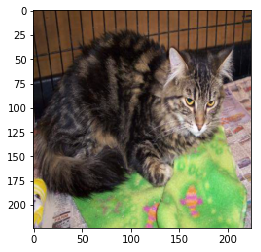

In [17]:
imshow(train[50][0])

## 데이터 제너레이터 만들기

In [18]:
train_data_gen = torch.utils.data.DataLoader(train,shuffle=True,batch_size=64,num_workers=3)
valid_data_gen = torch.utils.data.DataLoader(valid,batch_size=64,num_workers=3)

In [19]:
dataset_sizes = {'train':len(train_data_gen.dataset),'valid':len(valid_data_gen.dataset)}

In [20]:
dataloaders = {'train':train_data_gen,'valid':valid_data_gen}

## 네트워크 만들기

- 다음 코드에서는 RESNET18을 다운로드합니다.
- 다음 코드를 실행하기 위해서는 네트워크 연결 상태여야 합니다. 

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [22]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [23]:
# 오차함수와 옵티마이저
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 Epoch은 학습 단계와 검증 단계를 거침
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # 학습 모드 설정
            else:
                model.train(False)  # 검증 모드 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터 반
            for data in dataloaders[phase]:
                # 입력 데이터 가져오기
                inputs, labels = data

                # 데이터를 Vaariable로 만듦
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # 파라미터 기울기 초기화
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # 학습 단계에서만 수행, 역전파 + 옵티마이즈(최적화)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 통계
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss.item() / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델 복사(Deep Copy)
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 최적의 모델 가중치 로딩
    model.load_state_dict(best_model_wts)
    return model

In [26]:
%%time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=24)

Epoch 0/23
----------
train Loss: 0.0008 Acc: 0.9811
valid Loss: 0.0005 Acc: 0.9875

Epoch 1/23
----------
train Loss: 0.0005 Acc: 0.9890
valid Loss: 0.0005 Acc: 0.9870

Epoch 2/23
----------
train Loss: 0.0003 Acc: 0.9938
valid Loss: 0.0005 Acc: 0.9875

Epoch 3/23
----------
train Loss: 0.0002 Acc: 0.9965
valid Loss: 0.0005 Acc: 0.9875

Epoch 4/23
----------
train Loss: 0.0001 Acc: 0.9977
valid Loss: 0.0005 Acc: 0.9875

Epoch 5/23
----------
train Loss: 0.0001 Acc: 0.9982
valid Loss: 0.0005 Acc: 0.9870

Epoch 6/23
----------
train Loss: 0.0001 Acc: 0.9990
valid Loss: 0.0005 Acc: 0.9860

Epoch 7/23
----------
train Loss: 0.0001 Acc: 0.9993
valid Loss: 0.0005 Acc: 0.9875

Epoch 8/23
----------
train Loss: 0.0001 Acc: 0.9993
valid Loss: 0.0005 Acc: 0.9855

Epoch 9/23
----------
train Loss: 0.0001 Acc: 0.9993
valid Loss: 0.0005 Acc: 0.9880

Epoch 10/23
----------
train Loss: 0.0001 Acc: 0.9993
valid Loss: 0.0005 Acc: 0.9865

Epoch 11/23
----------
train Loss: 0.0001 Acc: 0.9992
valid Loss